In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson

#From Utilities .py scripts
from var_utils.functions import grangers_causation_matrix, adfuller_test
from var_utils.functions import cointegration_test, adjust, invert_transformation


data = pd.read_csv('data_macro_final-1999-2019-1.csv', index_col=[0])

maxlag = 10
test = 'ssr_chi2test'

data.drop(['CaptBurs Trimestral','INB'],axis=1,inplace=True)

#We see there are many of 
grangers_causation_matrix(data, variables = data.columns, maxlag = maxlag)

cointegration_test(data)

nobs = 3
df_train, df_test = data[0:-nobs], data[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

data_diff1 = df_train.diff().dropna()
data_diff2 = data_diff1.diff().dropna()

# ADF Test on each column
for name, column in data_diff2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')
    
#Cuenta Corriente > OK
#PBI > OK
#Ratio Adul-joven > diff=3
#TI Trimestral > OK
#Tasa hipotecaria > OK
#INB > diff=3 Delete variable.
#Precio_por_m2 > OK

#data_diff2['INB'] = data_diff2['INB'].diff()
data_diff2['Ratio adul-joven'] =data_diff2['Ratio adul-joven'].diff()
data_diff2.dropna(inplace=True)

model = VAR(data_diff2)
model.select_order(maxlags=5).summary()

model_fitted = model.fit(3)
out = durbin_watson(model_fitted.resid)

for col, val in zip(data.columns, out):
    print(adjust(col), ':', round(val, 2))
    
#model_fitted.summary()

# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 3

# Input data for forecasting
forecast_input = data_diff2.values[-lag_order:]
forecast_input

# Forecast
nobs=3
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=data_diff2.index[-nobs:], columns=data_diff2.columns + '_2d')

df_results = invert_transformation(data_diff2, df_forecast, second_diff=True)        

#df = data.drop(['CaptBurs Trimestral','INB'],axis=1)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Cuenta Corriente ::  112.45    > 83.9383   =>   True
PBI    ::  75.4      > 60.0627   =>   True
Ratio adul-joven ::  43.66     > 40.1749   =>   True
TI Trimestral ::  19.41     > 24.2761   =>   False
Tasa hipotecaria Trimestral ::  6.45      > 12.3212   =>   False
Precio_por_m2 ::  1.4       > 4.1296    =>   False
(76, 6)
(3, 6)
    Augmented Dickey-Fuller Test on "Cuenta Corriente" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2307
 No. Lags Chosen       = 10
 Critical value 1%     = -3.539
 Critical value 5%     = -2.909
 Critical value 10%    = -2.592
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PBI " 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signif

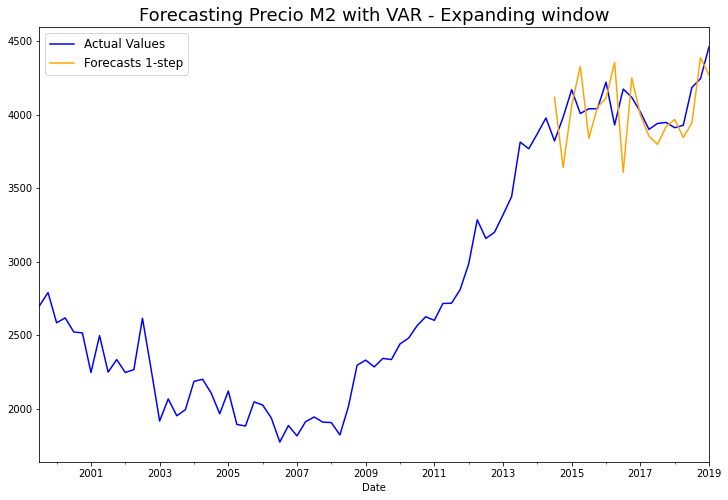

In [15]:
import seaborn as sns
#Backtesting: 79 rows (60-window, 19 test)
window_size = 60
n_records = data.shape[0]

date_fcst = []
forecast = []
actual_value = []
data_dict = {}

#Walk forward testing: Expanding window. Testing next period prediction.
for i in range(window_size, n_records):
    warnings.filterwarnings('ignore')
    train, test = data.iloc[0:i,:], data.iloc[i:i+1,:]
    idx_train, idx_test = data.iloc[0:i,:].index, data.iloc[i:i+1,:].index
    
    train_data_diff1 = train.diff().dropna()
    train_data_diff2 = train.diff().dropna()
    
    model = VAR(train_data_diff2).fit(3)
    # Input data for forecasting
    forecast_input = train_data_diff2.values[-lag_order:]
    
    # Forecast
    nobs=3
    fc = model.forecast(y=forecast_input, steps=nobs)
    reverting_fc = fc + train_data_diff1.values[-1] + train.values[-1]
    forecast.append(reverting_fc[0][-1])
    actual_value.append(train.values[-1][-1])
    date_fcst.append(idx_test[0])

data_backtest = pd.DataFrame({'Forecast-preciom2':forecast, 'ActualValue-preciom2':actual_value,
                             'Date':date_fcst})
data_backtest['Date'] = pd.to_datetime(data_backtest['Date'])
data = data.reset_index()
data['Fecha'] = pd.to_datetime(data['Fecha'])


#Plotting results:
fig = plt.figure(figsize=(12,8))
data.set_index('Fecha')['Precio_por_m2'].plot(color='blue')
data_backtest.set_index('Date')['Forecast-preciom2'].plot(color='orange')
#sns.lineplot(x='Date',y='Forecast-preciom2', data=data_backtest,ax=ax,color='green')

#ax.xaxis.set_major_formatter(mdates.DateFromatter("%b-"Y))

plt.title('Forecasting Precio M2 with VAR - Expanding window', fontsize=18)
plt.legend(['Actual Values','Forecasts 1-step'],fontsize=12)
plt.show()